**Primary Objective**:<br>
The project aims to use basic machine learning techniques to predict the revenues of the ABB Electrification business area.

**Success Metric**: <br>
Minimize the forecasting error, using metrics like Mean Absolute Error (MAE) or R-squared.

**Data Description**:<br>
Revenues CSV file for ABB and its peers (current as of Q3 2023)
Macroeconomic indicators provided by the World Economic Forum (WEF) CSV file (reflecting data as of October 2023).

**Machine Learning Models**:<br>
Use a simple linear regression model for revenue prediction.

**Additional analysis**:<br>
Sample indicators include GDP, unemployment rate, inflation, assuming these could influence revenues.

**Timeframe**:<br>
Historical Data: Last 10 years (up to Q3 2023).<br>
Forecast Period: Extend the analysis to project revenues until 2028.

**Results Interpretation**:<br>
In case of lower model effectiveness, review data, consider model adjustments, or conduct additional analysis of influencing factors.

**Results Reporting**:<br>
Present project results in a simple graph, containing key findings and insights.

In [1]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.interpolate import interp1d
from sklearn.svm import SVR
from math import sqrt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from itertools import product


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns

C:\Users\PLJAKRE\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Select Country/ies for the scope

In [2]:
#   countries = [
#      'China', 'India', 'United States', 'Indonesia', 'Brazil', 'Mexico','Japan', 'Philippines', 'Egypt', 'Vietnam',
#       'Turkey', 'Iran', 'Germany', 'Thailand', 'United Kingdom', 'France', 'Italy', 'South Africa',
#       'Myanmar', 'South Korea', 'Colombia', 'Spain', 'Argentina', 'Algeria', 'Iraq',
#       'Poland', 'Canada', 'Morocco', 'Saudi Arabia','Peru', 'Malaysia','Venezuela']

countries = ['United States', 'Poland']

# Select Macroeconomic Indicator for the scope

In [3]:
# indicator = [
#     'Gross domestic product, constant prices',
#     'Gross domestic product, current prices',
#     'Gross domestic product, deflator',
#     'Gross domestic product per capita, constant prices',
#     'Gross domestic product per capita, current prices',
#     'Inflation, average consumer prices',
#     'Current account balance',
#     'Total investment',
#     'Volume of imports of goods and services',
#     'Volume of Imports of goods',
#     'Volume of exports of goods and services',
#     'Volume of exports of goods'
# ]

indicator = 'Gross domestic product, deflator'

# Revenues file - Data modelling

In [4]:
# Loading the dataset with Company Revenue and Profitability
df = pd.read_csv("Financials v2 - Copy.csv", encoding='utf-8')

df

,Ticker,Company name,Segment,Segment Number,CIQ Formula,Currency,3/31/2010,6/30/2010,9/30/2010,12/31/2010,...,6/30/2021,9/30/2021,12/31/2021,3/31/2022,6/30/2022,9/30/2022,12/31/2022,3/31/2023,6/30/2023,9/30/2023
0,SWX:ABBN,ABB,Electrification,1,IQ_BUS_SEG_REV,USD,0.0,0.0,0.0,0.0,...,3406.0,3196.0,3445.0,3236.0,3414.0,3471.0,3663.0,3590.0,3735.0,3561.0
1,SWX:ABBN,ABB,Motion,2,IQ_BUS_SEG_REV,USD,0.0,0.0,0.0,0.0,...,1850.0,1673.0,1735.0,1572.0,1626.0,1702.0,1845.0,1940.0,1981.0,1947.0
2,SWX:ABBN,ABB,Process Automation,3,IQ_BUS_SEG_REV,USD,1735.0,1737.0,1859.0,2101.0,...,1540.0,1507.0,1805.0,1506.0,1529.0,1458.0,1551.0,1436.0,1553.0,1554.0
3,SWX:ABBN,ABB,Robotics & Discrete Automation,4,IQ_BUS_SEG_REV,USD,0.0,0.0,0.0,0.0,...,832.0,813.0,799.0,730.0,732.0,828.0,891.0,937.0,922.0,929.0
4,SWX:ABBN,ABB,"Corporate Costs, Intersegment Eliminations and...",5,IQ_BUS_SEG_REV,USD,-728.0,-716.0,-721.0,-834.0,...,-179.0,-161.0,-217.0,-79.0,-50.0,-53.0,-126.0,-44.0,-28.0,-23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,SHSE:601877,CHINT,Solar Energy Division,2,IQ_BUS_SEG_OPER_INC_ABS,CNY,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156,SHSE:601877,CHINT,Offset of Business Segment,3,IQ_BUS_SEG_OPER_INC_ABS,CNY,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,SHSE:601877,CHINT,Low Voltage Division,1,IQ_BUS_SEG_OPER_INC_ABS,USD,29.3,0.0,38.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158,SHSE:601877,CHINT,Solar Energy Division,2,IQ_BUS_SEG_OPER_INC_ABS,USD,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Unpivot the DataFrame, change column types and change the 'CIQ Formula column' values
df = pd.melt(df, id_vars=['Ticker', 'Company name', 'Segment', 'Segment Number', 'CIQ Formula', 'Currency'], var_name='Date', value_name='Value')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
df['CIQ Formula'] = df['CIQ Formula'].replace({'IQ_BUS_SEG_REV': 'Revenue', 'IQ_BUS_SEG_OPER_INC_ABS': 'Profitability', 'IQ_BUS_SEG_EBITDA_ABS': 'Profitability'})
df = df.sort_values(by=['Ticker', 'Date'])

df
# Data types sanity-check
print(df.dtypes)

Ticker                    object
Company name              object
Segment                   object
Segment Number             int64
CIQ Formula               object
Currency                  object
Date              datetime64[ns]
Value                    float64
dtype: object


In [6]:
# Check how many missing values are in 'Value' column. Focus on Revenues.
zero_table = df[(df['Value'] == 0) & (df['CIQ Formula'] == 'Revenue')]
zero_table

,Ticker,Company name,Segment,Segment Number,CIQ Formula,Currency,Date,Value
3727,ENXTPA:RXL,REXEL,Wholesale - Electronics,1,Revenue,EUR,2015-12-31,0.0
3728,ENXTPA:RXL,REXEL,Wholesale - Electronics,1,Revenue,USD,2015-12-31,0.0
8687,ENXTPA:RXL,REXEL,Wholesale - Electronics,1,Revenue,EUR,2023-09-30,0.0
8688,ENXTPA:RXL,REXEL,Wholesale - Electronics,1,Revenue,USD,2023-09-30,0.0
17,ENXTPA:SU,Schneider Electric,Energy Management,1,Revenue,EUR,2010-03-31,0.0
...,...,...,...,...,...,...,...,...
5772,XTRA:SIE,Siemens,Industrial Businesses (IB) - Siemens Healthineers,4,Revenue,EUR,2019-03-31,0.0
5773,XTRA:SIE,Siemens,Industrial Businesses (IB) - Digital Industries,1,Revenue,USD,2019-03-31,0.0
5774,XTRA:SIE,Siemens,Industrial Businesses (IB) - Smart Infrastructure,2,Revenue,USD,2019-03-31,0.0
5775,XTRA:SIE,Siemens,Industrial Businesses (IB) - Mobility,3,Revenue,USD,2019-03-31,0.0


Now we have confirmed that each column has been assigned the correct data type, but we've identified numerous missing values that require attention. Imputing the mean value may not be feasible due to the high prevalence of missing data. Let's explore whether Linear Regression would be a suitable approach.

In [7]:
# Extract the year and month from the 'Date' column
df['YearMonth'] = df['Date'].dt.to_period('M')

# Map Year-Month to a numerical representation
df['YearMonthNumeric'] = df['YearMonth'].apply(lambda x: x.year * 12 + x.month)

# Select rows with 'Value' == 0 and 'Value' != 0
df_missing = df[df['Value'] == 0]
df_not_missing = df[df['Value'] != 0].copy()

# Create a new column combining 'Ticker', 'Currency', 'CIQ Formula', and 'Segment' for unique combinations
df_not_missing['UniqueCombination'] = (
    df_not_missing['Ticker'] + '_' + df_not_missing['Currency'] + '_' +
    df_not_missing['CIQ Formula'] + '_' + df_not_missing['Segment']
)

result_df = pd.DataFrame()

# Iterate over unique combinations
for combination, group in df_not_missing.groupby('UniqueCombination'):
    # Check if there are any samples for training
    if len(group) > 0:
        # Prepare data for regression
        X_train = group[['YearMonthNumeric']].values.reshape(-1, 1)
        y_train = group['Value'].values

        # Filter the missing values based on the current combination
        missing_filter = (
            (df_missing['Ticker'] + '_' + df_missing['Currency'] + '_' +
             df_missing['CIQ Formula'] + '_' + df_missing['Segment']) == combination
        )
        indices = df_missing.loc[missing_filter].index

        # Check if there are any missing values for the current combination
        if len(indices) > 0:
            # Initialize the linear regression model
            model = LinearRegression()
            model.fit(X_train, y_train)
            predicted_values = model.predict(df_missing.loc[missing_filter, ['YearMonthNumeric']].values.reshape(-1, 1))
            df.loc[indices, 'Value'] = predicted_values
    else:
        print(f"Not enough samples for {combination}, skipping...")

df

,Ticker,Company name,Segment,Segment Number,CIQ Formula,Currency,Date,Value,YearMonth,YearMonthNumeric
5,ENXTPA:LR,Legrand,Electric Equipment,1,Revenue,EUR,2010-03-31,911.7,2010-03,24123
6,ENXTPA:LR,Legrand,Electric Equipment,1,Revenue,USD,2010-03-31,1232.8,2010-03,24123
85,ENXTPA:LR,Legrand,Electric Equipment,1,Profitability,EUR,2010-03-31,0.0,2010-03,24123
86,ENXTPA:LR,Legrand,Electric Equipment,1,Profitability,USD,2010-03-31,0.0,2010-03,24123
165,ENXTPA:LR,Legrand,Electric Equipment,1,Revenue,EUR,2010-06-30,998.4,2010-06,24126
...,...,...,...,...,...,...,...,...,...,...
8732,XTRA:SIE,Siemens,Industrial Businesses (IB) - Siemens Healthineers,4,Profitability,EUR,2023-09-30,856.0,2023-09,24285
8733,XTRA:SIE,Siemens,Industrial Businesses (IB) - Digital Industries,1,Profitability,USD,2023-09-30,1390.8,2023-09,24285
8734,XTRA:SIE,Siemens,Industrial Businesses (IB) - Smart Infrastructure,2,Profitability,USD,2023-09-30,843.6,2023-09,24285
8735,XTRA:SIE,Siemens,Industrial Businesses (IB) - Mobility,3,Profitability,USD,2023-09-30,219.1,2023-09,24285


Imputing completed

# Revenues file - Drawing a chart for ABB Electrification

In [8]:
# Create new dataset - ABB, Electrification
abb_data = df[(df['Company name'] == 'ABB') & (df['CIQ Formula'] == 'Revenue') & (df['Segment'] == 'Electrification')]

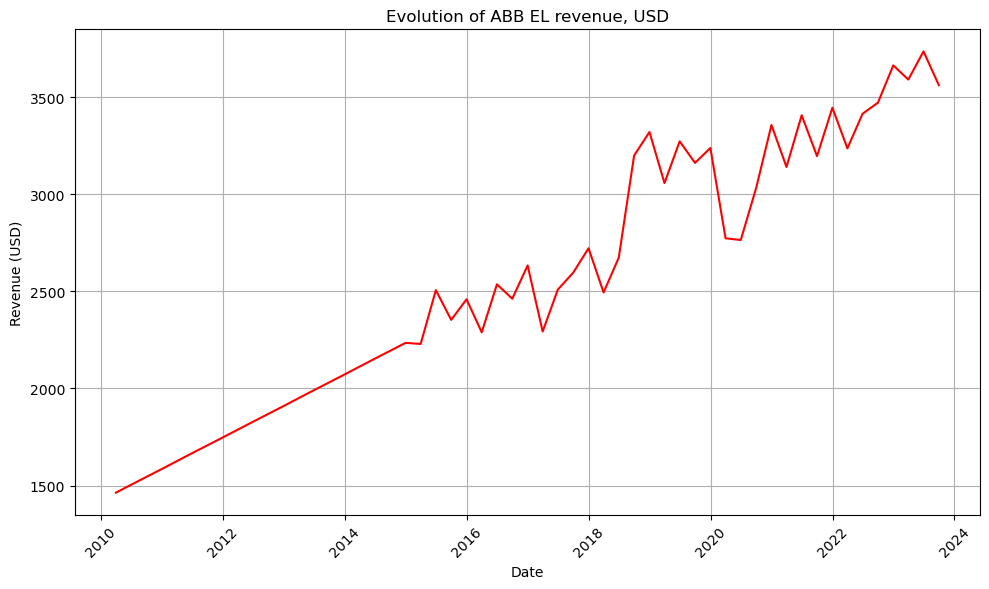

In [9]:
# Create the plot chart
abb_data = abb_data.sort_values(by='Date')
plt.figure(figsize=(10, 6))
plt.plot(abb_data['Date'], abb_data['Value'], linestyle='-', color='r')
plt.title('Evolution of ABB EL revenue, USD')
plt.xlabel('Date')
plt.ylabel('Revenue (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

# Revenues file - Checking other companies

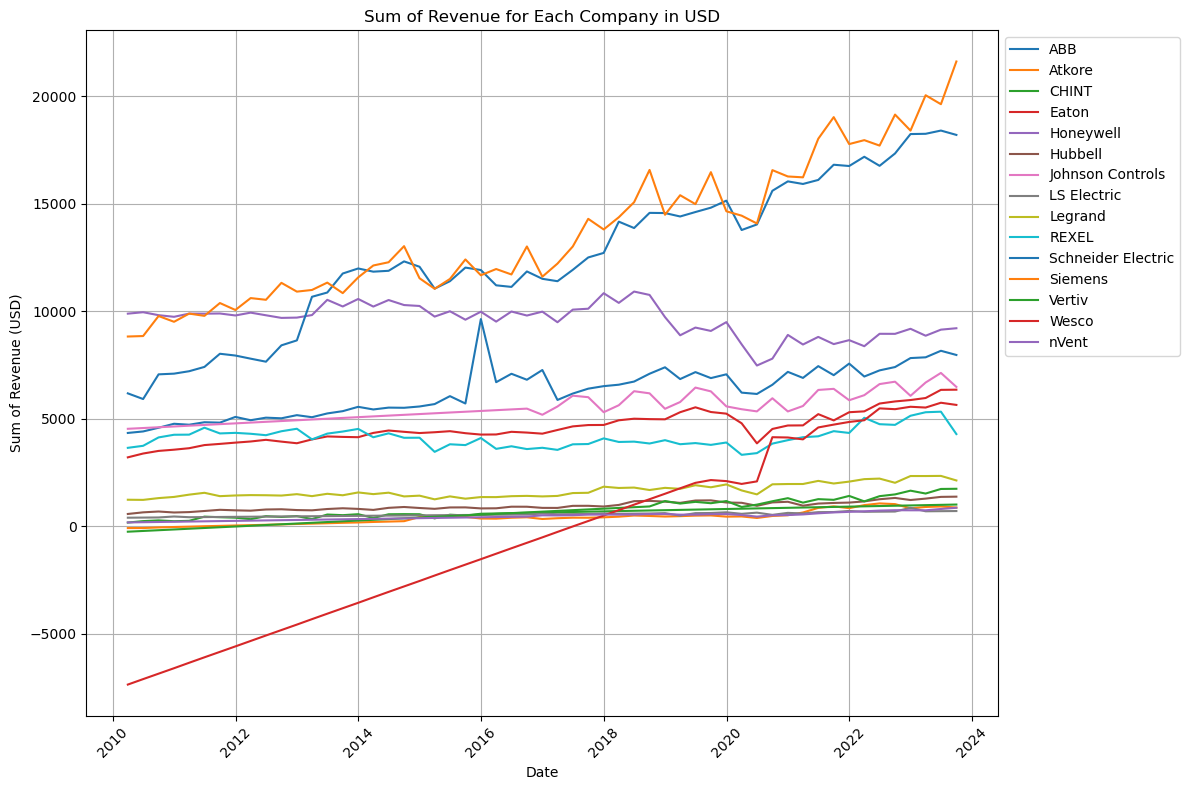

In [10]:
# Group by'Company Name' i 'Date' and summarize Revenues in USD
revenue_data = df[df['CIQ Formula'] == 'Revenue']
summed_data = revenue_data.groupby(['Company name', 'Date', 'Currency'], as_index=False)['Value'].sum()
summed_data_usd = summed_data[summed_data['Currency'] == 'USD']

# Create the plot
plt.figure(figsize=(12, 8))

# Go through all companies
for company in summed_data_usd['Company name'].unique():
    company_data = summed_data_usd[summed_data_usd['Company name'] == company]
    plt.plot(company_data['Date'], company_data['Value'], label=company, linestyle='-')

plt.title('Sum of Revenue for Each Company in USD')
plt.xlabel('Date')
plt.ylabel('Sum of Revenue (USD)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()

In summary, it's crucial to note that a comprehensive analysis is hindered by the absence of reliable pre-2018 data for certain companies, such as Wesco. Therefore, to align with the primary objective of developing a ML model tailored to ABB Electrification, our focus will be exclusively on that specific dataset.
However it could be also used for other companies, like Schneider Electric or Siemens.

# Revenues file - Applying 2028 Revenues prediction for ABB, Electrification

In [11]:
abb_data

,Ticker,Company name,Segment,Segment Number,CIQ Formula,Currency,Date,Value,YearMonth,YearMonthNumeric
0,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2010-03-31,1463.604129,2010-03,24123
160,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2010-06-30,1504.187562,2010-06,24126
320,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2010-09-30,1544.770996,2010-09,24129
480,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2010-12-31,1585.354429,2010-12,24132
640,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2011-03-31,1625.937862,2011-03,24135
800,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2011-06-30,1666.521295,2011-06,24138
960,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2011-09-30,1707.104729,2011-09,24141
1120,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2011-12-31,1747.688162,2011-12,24144
1280,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2012-03-31,1788.271595,2012-03,24147
1440,SWX:ABBN,ABB,Electrification,1,Revenue,USD,2012-06-30,1828.855028,2012-06,24150


In [12]:
# Define the End Date 
end_date = '2028-12-31'

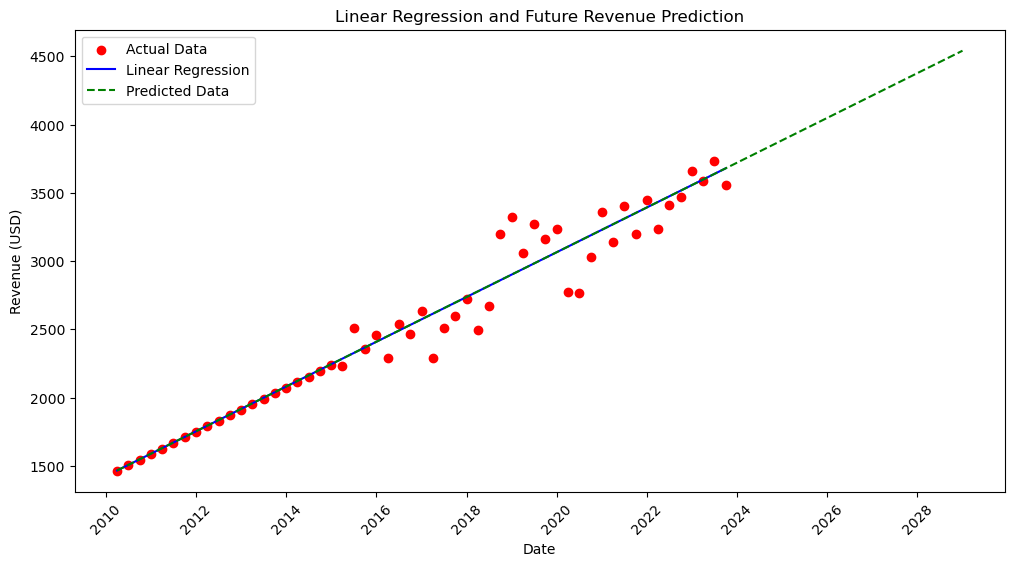

Predicted Revenue for 2028-12-31: 4541.37 USD
Mean Absolute Error (MAE) on training data: 98.27
Mean Squared Error (MSE) on training data: 21048.48
Root Mean Squared Error (RMSE) on training data: 145.08
R-squared (R²) on training data: 0.9534


In [13]:
# Define the formula for linear regression model
def linear_regression_chart_and_metrics(data, end_date, test_size=0.2, random_state=42):
    X = (data['Date'] - data['Date'].min()).dt.days.values.reshape(-1, 1)
    y = data['Value']

    # Split the data into training and testing sets and train the model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict revenues for the entire dataset
    y_pred = model.predict(X)

    # Generate dates up to the specified end date
    future_dates = pd.date_range(start=data['Date'].min(), end=end_date, freq='Q')
    future_days = (future_dates - data['Date'].min()).days.values.reshape(-1, 1)

    # Predict revenues for future dates
    future_predictions = model.predict(future_days)

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.scatter(data['Date'], data['Value'], label='Actual Data', color='red')
    plt.plot(data['Date'], y_pred, label='Linear Regression', color='blue')
    plt.plot(future_dates, future_predictions, label='Predicted Data', linestyle='dashed', color='green')
    plt.xlabel('Date')
    plt.ylabel('Revenue (USD)')
    plt.title('Linear Regression and Future Revenue Prediction')
    plt.legend()
    plt.xticks(rotation=45)

    plt.show()

    # Calculate performance metrics on the training set
    y_pred_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_train)

    # Print the results
    end_date_prediction = model.predict([[ (pd.to_datetime(end_date) - data['Date'].min()).days ]])
    print(f'Predicted Revenue for {end_date}: {end_date_prediction[0]:.2f} USD')
    print(f'Mean Absolute Error (MAE) on training data: {mae_train:.2f}')
    print(f'Mean Squared Error (MSE) on training data: {mse_train:.2f}')
    print(f'Root Mean Squared Error (RMSE) on training data: {rmse_train:.2f}')
    print(f'R-squared (R²) on training data: {r2_train:.4f}')

linear_regression_chart_and_metrics(abb_data, end_date, test_size=0.2, random_state=42)

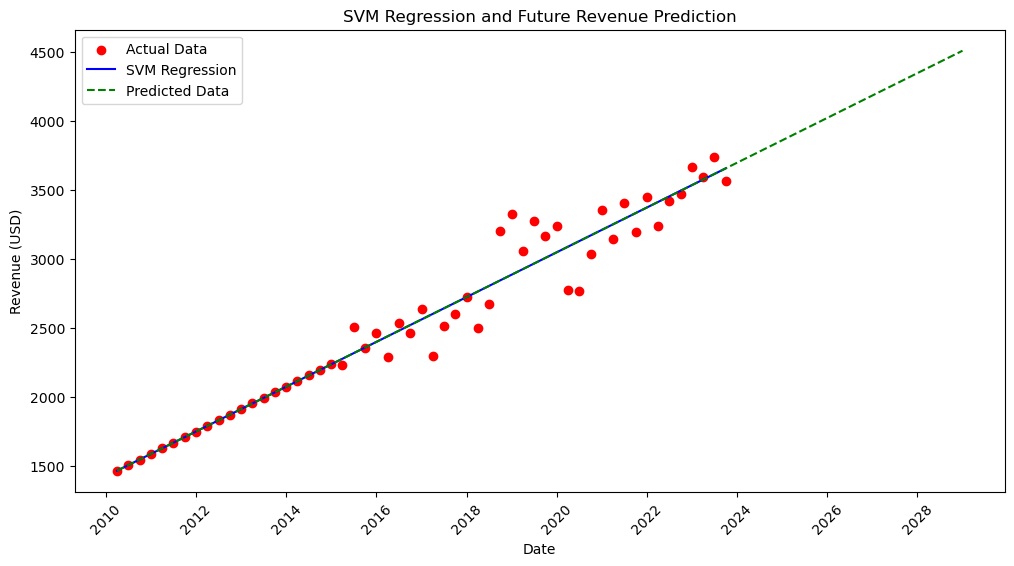

Predicted Revenue for 2028-12-31: 4506.31 USD
Mean Absolute Error (MAE) on training data: 93.30
Mean Squared Error (MSE) on training data: 21197.78
Root Mean Squared Error (RMSE) on training data: 145.59
R-squared (R²) on training data: 0.9514


In [14]:
# Define the formula for support vector regression model
def svm_regression_chart_and_metrics(data, end_date):
    X = (data['Date'] - data['Date'].min()).dt.days.values.reshape(-1, 1)
    y = data['Value']

    # Train the model
    svm_model = SVR(kernel='linear')
    svm_model.fit(X, y)

    # Generate dates up to the specified end date
    future_dates = pd.date_range(start=data['Date'].min(), end=end_date, freq='Q')
    future_days = (future_dates - data['Date'].min()).days.values.reshape(-1, 1)

    # Predict revenues for future dates
    future_predictions = svm_model.predict(future_days)

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.scatter(data['Date'], data['Value'], label='Actual Data', color='red')
    plt.plot(data['Date'], svm_model.predict(X), label='SVM Regression', color='blue')
    plt.plot(future_dates, future_predictions, label='Predicted Data', linestyle='dashed', color='green')
    plt.xlabel('Date')
    plt.ylabel('Revenue (USD)')
    plt.title('SVM Regression and Future Revenue Prediction')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.show()

    # Print predicted revenues for the end date
    end_date_prediction = svm_model.predict([[ (pd.to_datetime(end_date) - data['Date'].min()).days ]])
    print(f'Predicted Revenue for {end_date}: {end_date_prediction[0]:.2f} USD')

    # Performance Metrics
    y_pred_train = svm_model.predict(X)
    mae_train = mean_absolute_error(y, y_pred_train)
    mse_train = mean_squared_error(y, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y, y_pred_train)

    print(f'Mean Absolute Error (MAE) on training data: {mae_train:.2f}')
    print(f'Mean Squared Error (MSE) on training data: {mse_train:.2f}')
    print(f'Root Mean Squared Error (RMSE) on training data: {rmse_train:.2f}')
    print(f'R-squared (R²) on training data: {r2_train:.4f}')

svm_regression_chart_and_metrics(abb_data, end_date)

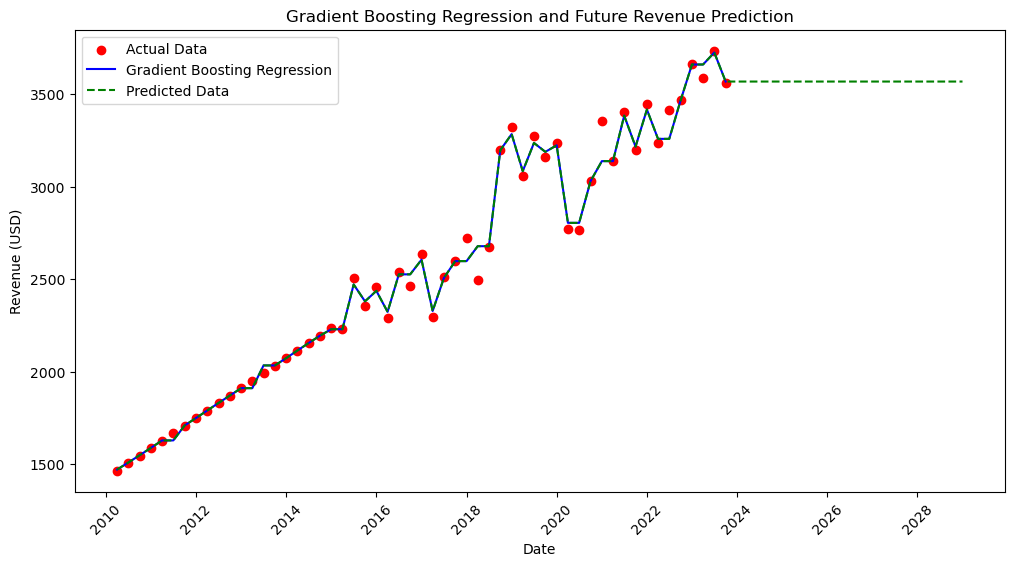

Predicted Revenue for 2028-12-31: 3568.27 USD
Mean Absolute Error (MAE) on test data: 89.41
Mean Squared Error (MSE) on test data: 12426.10
Root Mean Squared Error (RMSE) on test data: 111.47
R-squared (R²) on test data: 0.9665


In [15]:
# Define the formula for gradient boosting regression model
def gradient_boosting_chart_and_metrics(data, end_date):
    # Feature engineering: Use the number of days since the minimum date
    X = (data['Date'] - data['Date'].min()).dt.days.values.reshape(-1, 1)
    y = data['Value']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Gradient Boosting Regressor model
    gb_model = GradientBoostingRegressor()
    gb_model.fit(X_train, y_train)

    # Predictions on the test set
    y_pred_test = gb_model.predict(X_test)

    # Generate dates up to the specified end date
    future_dates = pd.date_range(start=data['Date'].min(), end=end_date, freq='Q')
    future_days = (future_dates - data['Date'].min()).days.values.reshape(-1, 1)

    # Predict revenues for future dates
    future_predictions = gb_model.predict(future_days)

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.scatter(data['Date'], data['Value'], label='Actual Data', color='red')
    plt.plot(data['Date'], gb_model.predict(X), label='Gradient Boosting Regression', color='blue')
    plt.plot(future_dates, future_predictions, label='Predicted Data', linestyle='dashed', color='green')
    plt.xlabel('Date')
    plt.ylabel('Revenue (USD)')
    plt.title('Gradient Boosting Regression and Future Revenue Prediction')
    plt.legend()
    plt.xticks(rotation=45)

    plt.show()
    
    # Print predicted revenues for the end date
    end_date_prediction = gb_model.predict([[ (pd.to_datetime(end_date) - data['Date'].min()).days ]])
    print(f'Predicted Revenue for {end_date}: {end_date_prediction[0]:.2f} USD')
    
    # Performance Metrics on the test set
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)

    print(f'Mean Absolute Error (MAE) on test data: {mae_test:.2f}')
    print(f'Mean Squared Error (MSE) on test data: {mse_test:.2f}')
    print(f'Root Mean Squared Error (RMSE) on test data: {rmse_test:.2f}')
    print(f'R-squared (R²) on test data: {r2_test:.4f}')

gradient_boosting_chart_and_metrics(abb_data, end_date)

The Gradient Boosting Regression model suggests that the predicted revenue remains stagnant. This could be attributed to the suboptimal quality of input data.

Comparatively, the Linear Regression model exhibits a slightly lower Mean Absolute Error (MAE), implying superior accuracy in predicting revenue values. Meanwhile, the Support Vector Machine (SVM) model demonstrates a slightly lower Mean Squared Error (MSE) and Root Mean Squared Error (RMSE), indicating reduced errors in revenue prediction.

Given these observations, we have decided to proceed with the Support Vector Machine (SVM) model for its favorable performance characteristics.

In [16]:
def svm_regression_table(data, end_date):
    X = (data['Date'] - data['Date'].min()).dt.days.values.reshape(-1, 1)
    y = data['Value']

    # Train a Support Vector Machine for regression model
    svm_model = SVR(kernel='linear')
    svm_model.fit(X, y)

    # Generate dates up to the specified end date
    future_dates = pd.date_range(start=data['Date'].min(), end=end_date, freq='Q')
    future_days = (future_dates - data['Date'].min()).days.values.reshape(-1, 1)

    # Predict revenues for future dates
    future_predictions = svm_model.predict(future_days)

    # Create a DataFrame with Actual Data and Predicted Data
    predictions_df = pd.DataFrame({
        'Date': data['Date'].tolist() + future_dates.tolist(),
        'Company Name': [data['Company name'].iloc[0]] * len(data) + [np.nan] * len(future_dates),
        'Segment': [data['Segment'].iloc[0]] * len(data) + [np.nan] * len(future_dates),
        'Measure': ['Revenue'] * len(data) + [np.nan] * len(future_dates),
        'Actual Data': data['Value'].tolist() + [np.nan] * len(future_dates),
        'Predicted Data': np.concatenate([svm_model.predict(X), future_predictions]),
    })
    
    # Fill NaN values in 'Company Name', 'Segment', and 'Measure' columns with the mode
    predictions_df['Company Name'].fillna(predictions_df['Company Name'].mode().iloc[0], inplace=True)
    predictions_df['Segment'].fillna(predictions_df['Segment'].mode().iloc[0], inplace=True)
    predictions_df['Measure'].fillna(predictions_df['Measure'].mode().iloc[0], inplace=True)
    
    # Create 'Value' column based on conditions
    predictions_df['Value'] = np.where(predictions_df['Actual Data'].notna(), predictions_df['Actual Data'], predictions_df['Predicted Data'])
    
    # Keep only unique dates with the highest priority to 'Actual Data'
    predictions_df = predictions_df.sort_values(by='Actual Data', ascending=False).drop_duplicates(subset='Date', keep='first')

    # Drop 'Actual Data' and 'Predicted Data' columns
    predictions_df.drop(['Actual Data', 'Predicted Data'], axis=1, inplace=True)
    
    # Sort by date
    predictions_df = predictions_df.sort_values(by='Date')

    return predictions_df

predictions_df = svm_regression_table(abb_data, end_date)

In [17]:
# Data type sanity-check
predictions_df.dtypes

Date            datetime64[ns]
Company Name            object
Segment                 object
Measure                 object
Value                  float64
dtype: object

In [18]:
predictions_df.to_csv('predictions.csv', index=False)

# Macroeconomics file - Data modelling

In [19]:
# Load the dataset with macroeconomics
macro = pd.read_csv("WEOOct2023all.csv")
macro

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,288.87","1,021.60",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,"See notes for: Gross domestic product, consta...",NaN,...,-2.351,-20.737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,547.29","1,232.86",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,20.136,14.941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,81.007,67.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8621,698,ZWE,NGDP_FY,Zimbabwe,Gross domestic product corresponding to fiscal...,Gross domestic product corresponding to fiscal...,National currency,Billions,Source: Ministry of Finance or Treasury Latest...,NaN,...,"1,380.14","3,187.63","12,292.67","111,864.93","474,084.10","1,102,309.64","2,089,955.60","3,126,416.82","4,128,929.25",2021.0
8622,698,ZWE,BCA,Zimbabwe,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions,Source: Reserve Bank of Zimbabwe and Ministry ...,-0.301,...,0.678,0.348,0.321,0.28,-0.317,-0.411,-0.466,-0.512,-0.55,2022.0
8623,698,ZWE,BCA_NGDPD,Zimbabwe,Current account balance,Current account is all transactions other than...,Percent of GDP,NaN,"See notes for: Gross domestic product, curren...",NaN,...,2.521,0.968,1.019,0.863,-0.673,-0.827,-0.922,-1.081,-1.12,2022.0
8624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Unpivot the DataFrame, delete all unnecessary columns and all NaN's. Leave dates starting from 2010
macro = macro.drop(['WEO Country Code', 'WEO Subject Code', 'Subject Notes', 'Country/Series-specific Notes'], axis=1)
macro = pd.melt(macro, id_vars=['ISO', 'Country', 'Subject Descriptor', 'Units', 'Scale'], var_name='Date', value_name='Value')
macro = macro.dropna(how='all')
macro = macro.dropna(subset=['Value'])
macro = macro[macro['Date'] != 'Estimates Start After']
macro = macro[macro['Date'] >= '2010']

macro

,ISO,Country,Subject Descriptor,Units,Scale,Date,Value
258780,AFG,Afghanistan,"Gross domestic product, constant prices",National currency,Billions,2010,899.956
258781,AFG,Afghanistan,"Gross domestic product, constant prices",Percent change,NaN,2010,8.438
258782,AFG,Afghanistan,"Gross domestic product, current prices",National currency,Billions,2010,711.759
258783,AFG,Afghanistan,"Gross domestic product, current prices",U.S. dollars,Billions,2010,15.325
258784,AFG,Afghanistan,"Gross domestic product, current prices",Purchasing power parity; international dollars,Billions,2010,46.309
...,...,...,...,...,...,...,...
422667,ZWE,Zimbabwe,General government gross debt,National currency,Billions,2028,"1,763,004.39"
422668,ZWE,Zimbabwe,General government gross debt,Percent of GDP,NaN,2028,42.699
422669,ZWE,Zimbabwe,Gross domestic product corresponding to fiscal...,National currency,Billions,2028,"4,128,929.25"
422670,ZWE,Zimbabwe,Current account balance,U.S. dollars,Billions,2028,-0.55


In [21]:
# Data type sanity-check
print(macro.dtypes)

ISO                   object
Country               object
Subject Descriptor    object
Units                 object
Scale                 object
Date                  object
Value                 object
dtype: object


In [22]:
# Fix formats and sort by ISO and Date
macro['Date'] = pd.to_datetime(macro['Date'], errors='coerce')
macro['Value'] = pd.to_numeric(macro['Value'], errors='coerce')
macro = macro.sort_values(by=['ISO', 'Date'])

macro

,ISO,Country,Subject Descriptor,Units,Scale,Date,Value
259132,ABW,Aruba,"Gross domestic product, constant prices",National currency,Billions,2010-01-01,4.485
259133,ABW,Aruba,"Gross domestic product, constant prices",Percent change,NaN,2010-01-01,-2.733
259134,ABW,Aruba,"Gross domestic product, current prices",National currency,Billions,2010-01-01,4.392
259135,ABW,Aruba,"Gross domestic product, current prices",U.S. dollars,Billions,2010-01-01,2.454
259136,ABW,Aruba,"Gross domestic product, current prices",Purchasing power parity; international dollars,Billions,2010-01-01,3.434
...,...,...,...,...,...,...,...
422667,ZWE,Zimbabwe,General government gross debt,National currency,Billions,2028-01-01,NaN
422668,ZWE,Zimbabwe,General government gross debt,Percent of GDP,NaN,2028-01-01,42.699
422669,ZWE,Zimbabwe,Gross domestic product corresponding to fiscal...,National currency,Billions,2028-01-01,NaN
422670,ZWE,Zimbabwe,Current account balance,U.S. dollars,Billions,2028-01-01,-0.550


In [23]:
# Investigate Indicators
unique_sd = macro['Subject Descriptor'].unique()
unique_sd

array(['Gross domestic product, constant prices',
       'Gross domestic product, current prices',
       'Gross domestic product, deflator',
       'Gross domestic product per capita, constant prices',
       'Gross domestic product per capita, current prices',
       'Gross domestic product based on purchasing-power-parity (PPP) share of world total',
       'Implied PPP conversion rate', 'Gross national savings',
       'Inflation, average consumer prices',
       'Inflation, end of period consumer prices', 'Unemployment rate',
       'Population', 'General government revenue',
       'General government total expenditure',
       'General government net lending/borrowing',
       'General government primary net lending/borrowing',
       'General government gross debt',
       'Gross domestic product corresponding to fiscal year, current prices',
       'Current account balance', 'Total investment',
       'Volume of imports of goods and services',
       'Volume of Imports of good

In [24]:
# Remove unnecessary Indicators
values_to_remove = [
    'Gross domestic product based on purchasing-power-parity (PPP) share of world total',
    'Implied PPP conversion rate', 'Gross national savings',
    'Inflation, end of period consumer prices', 'Unemployment rate', 'Population',
    'General government revenue', 'General government total expenditure',
    'General government net lending/borrowing', 'General government primary net lending/borrowing',
    'Gross domestic product corresponding to fiscal year, current prices',
    'General government structural balance', 'General government net debt', 'Employment',
    'Output gap in percent of potential GDP'
]
macro = macro[~macro['Subject Descriptor'].isin(values_to_remove)]
macro = macro.dropna(subset=['Value'])

macro

,ISO,Country,Subject Descriptor,Units,Scale,Date,Value
259132,ABW,Aruba,"Gross domestic product, constant prices",National currency,Billions,2010-01-01,4.485
259133,ABW,Aruba,"Gross domestic product, constant prices",Percent change,NaN,2010-01-01,-2.733
259134,ABW,Aruba,"Gross domestic product, current prices",National currency,Billions,2010-01-01,4.392
259135,ABW,Aruba,"Gross domestic product, current prices",U.S. dollars,Billions,2010-01-01,2.454
259136,ABW,Aruba,"Gross domestic product, current prices",Purchasing power parity; international dollars,Billions,2010-01-01,3.434
...,...,...,...,...,...,...,...
422649,ZWE,Zimbabwe,Volume of Imports of goods,Percent change,NaN,2028-01-01,4.140
422651,ZWE,Zimbabwe,Volume of exports of goods,Percent change,NaN,2028-01-01,9.815
422668,ZWE,Zimbabwe,General government gross debt,Percent of GDP,NaN,2028-01-01,42.699
422670,ZWE,Zimbabwe,Current account balance,U.S. dollars,Billions,2028-01-01,-0.550


In [25]:
#Delete more unnecessary columns
macro = macro.drop(['ISO', 'Units', 'Scale'], axis=1)
macro

,Country,Subject Descriptor,Date,Value
259132,Aruba,"Gross domestic product, constant prices",2010-01-01,4.485
259133,Aruba,"Gross domestic product, constant prices",2010-01-01,-2.733
259134,Aruba,"Gross domestic product, current prices",2010-01-01,4.392
259135,Aruba,"Gross domestic product, current prices",2010-01-01,2.454
259136,Aruba,"Gross domestic product, current prices",2010-01-01,3.434
...,...,...,...,...
422649,Zimbabwe,Volume of Imports of goods,2028-01-01,4.140
422651,Zimbabwe,Volume of exports of goods,2028-01-01,9.815
422668,Zimbabwe,General government gross debt,2028-01-01,42.699
422670,Zimbabwe,Current account balance,2028-01-01,-0.550


Now the dataset with macroeconomic indicators contains only convinient stuff. Next step is to pivot measures.

In [26]:
# Check for duplicate entries in the index - just in case
duplicate_rows = macro[macro.duplicated(subset=['Country', 'Date', 'Subject Descriptor'], keep=False)]
macro = macro.groupby(['Country', 'Date', 'Subject Descriptor'])['Value'].mean().reset_index()

# Pivot table and reset index
pivot_macro = macro.pivot_table(index=['Country', 'Date'], columns='Subject Descriptor', values='Value').reset_index()

pivot_macro

Subject Descriptor,Country,Date,Current account balance,General government gross debt,"Gross domestic product per capita, constant prices","Gross domestic product per capita, current prices","Gross domestic product, constant prices","Gross domestic product, current prices","Gross domestic product, deflator","Inflation, average consumer prices",Total investment,Volume of Imports of goods,Volume of exports of goods,Volume of exports of goods and services,Volume of imports of goods and services
0,Afghanistan,2010-01-01,16.9700,31.2405,NaN,631.490,454.1970,257.797667,79.088,39.2040,30.269,34.955,-1.751,11.482,33.497
1,Afghanistan,2011-01-01,15.6640,35.1135,NaN,714.700,482.3725,301.482000,87.264,48.5155,26.407,8.697,-10.762,1.670,13.486
2,Afghanistan,2012-01-01,6.5345,38.3120,NaN,784.611,13.9680,40.119000,94.641,48.5790,25.340,33.338,9.889,-19.843,29.319
3,Afghanistan,2013-01-01,0.8675,42.0075,NaN,754.402,5.6830,41.977000,96.764,52.4015,23.093,7.693,6.042,-39.683,3.479
4,Afghanistan,2014-01-01,3.9495,55.8140,NaN,746.922,2.6970,45.030000,99.809,53.3220,17.460,-16.190,35.435,51.776,-14.465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,Zimbabwe,2024-01-01,-0.4950,56.9440,NaN,NaN,12.6685,47.086000,NaN,222.3990,NaN,3.256,-1.626,NaN,NaN
3669,Zimbabwe,2025-01-01,-0.6190,52.2010,NaN,NaN,13.0010,49.731000,NaN,128.0780,NaN,3.519,1.699,NaN,NaN
3670,Zimbabwe,2026-01-01,-0.6940,48.2130,NaN,NaN,13.2860,51.430000,NaN,72.3420,NaN,3.343,4.309,NaN,NaN
3671,Zimbabwe,2027-01-01,-0.7965,48.4160,NaN,NaN,13.6275,51.236000,NaN,52.2700,NaN,4.415,6.511,NaN,NaN


This dataset is almost ready to be merged with the first one. There are only 2 additional columns missing. Since we are focuing on ABB Electrification this time, I will add these values as strings for the time being.

In [27]:
# Add two columns
pivot_macro['Company Name'] = 'ABB'
pivot_macro['Segment'] = 'Electrification'
pivot_macro

Subject Descriptor,Country,Date,Current account balance,General government gross debt,"Gross domestic product per capita, constant prices","Gross domestic product per capita, current prices","Gross domestic product, constant prices","Gross domestic product, current prices","Gross domestic product, deflator","Inflation, average consumer prices",Total investment,Volume of Imports of goods,Volume of exports of goods,Volume of exports of goods and services,Volume of imports of goods and services,Company Name,Segment
0,Afghanistan,2010-01-01,16.9700,31.2405,NaN,631.490,454.1970,257.797667,79.088,39.2040,30.269,34.955,-1.751,11.482,33.497,ABB,Electrification
1,Afghanistan,2011-01-01,15.6640,35.1135,NaN,714.700,482.3725,301.482000,87.264,48.5155,26.407,8.697,-10.762,1.670,13.486,ABB,Electrification
2,Afghanistan,2012-01-01,6.5345,38.3120,NaN,784.611,13.9680,40.119000,94.641,48.5790,25.340,33.338,9.889,-19.843,29.319,ABB,Electrification
3,Afghanistan,2013-01-01,0.8675,42.0075,NaN,754.402,5.6830,41.977000,96.764,52.4015,23.093,7.693,6.042,-39.683,3.479,ABB,Electrification
4,Afghanistan,2014-01-01,3.9495,55.8140,NaN,746.922,2.6970,45.030000,99.809,53.3220,17.460,-16.190,35.435,51.776,-14.465,ABB,Electrification
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,Zimbabwe,2024-01-01,-0.4950,56.9440,NaN,NaN,12.6685,47.086000,NaN,222.3990,NaN,3.256,-1.626,NaN,NaN,ABB,Electrification
3669,Zimbabwe,2025-01-01,-0.6190,52.2010,NaN,NaN,13.0010,49.731000,NaN,128.0780,NaN,3.519,1.699,NaN,NaN,ABB,Electrification
3670,Zimbabwe,2026-01-01,-0.6940,48.2130,NaN,NaN,13.2860,51.430000,NaN,72.3420,NaN,3.343,4.309,NaN,NaN,ABB,Electrification
3671,Zimbabwe,2027-01-01,-0.7965,48.4160,NaN,NaN,13.6275,51.236000,NaN,52.2700,NaN,4.415,6.511,NaN,NaN,ABB,Electrification


Once we try to merge these two columns, there might be an issue with Date column. Macro database is showing full year data, while predictions df is quarterly based. Let's change this column to show full year in both cases.

In [28]:
# Change 'Date' column to show year only
pivot_macro['Date'] = pivot_macro['Date'].dt.year
pivot_macro

Subject Descriptor,Country,Date,Current account balance,General government gross debt,"Gross domestic product per capita, constant prices","Gross domestic product per capita, current prices","Gross domestic product, constant prices","Gross domestic product, current prices","Gross domestic product, deflator","Inflation, average consumer prices",Total investment,Volume of Imports of goods,Volume of exports of goods,Volume of exports of goods and services,Volume of imports of goods and services,Company Name,Segment
0,Afghanistan,2010,16.9700,31.2405,NaN,631.490,454.1970,257.797667,79.088,39.2040,30.269,34.955,-1.751,11.482,33.497,ABB,Electrification
1,Afghanistan,2011,15.6640,35.1135,NaN,714.700,482.3725,301.482000,87.264,48.5155,26.407,8.697,-10.762,1.670,13.486,ABB,Electrification
2,Afghanistan,2012,6.5345,38.3120,NaN,784.611,13.9680,40.119000,94.641,48.5790,25.340,33.338,9.889,-19.843,29.319,ABB,Electrification
3,Afghanistan,2013,0.8675,42.0075,NaN,754.402,5.6830,41.977000,96.764,52.4015,23.093,7.693,6.042,-39.683,3.479,ABB,Electrification
4,Afghanistan,2014,3.9495,55.8140,NaN,746.922,2.6970,45.030000,99.809,53.3220,17.460,-16.190,35.435,51.776,-14.465,ABB,Electrification
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,Zimbabwe,2024,-0.4950,56.9440,NaN,NaN,12.6685,47.086000,NaN,222.3990,NaN,3.256,-1.626,NaN,NaN,ABB,Electrification
3669,Zimbabwe,2025,-0.6190,52.2010,NaN,NaN,13.0010,49.731000,NaN,128.0780,NaN,3.519,1.699,NaN,NaN,ABB,Electrification
3670,Zimbabwe,2026,-0.6940,48.2130,NaN,NaN,13.2860,51.430000,NaN,72.3420,NaN,3.343,4.309,NaN,NaN,ABB,Electrification
3671,Zimbabwe,2027,-0.7965,48.4160,NaN,NaN,13.6275,51.236000,NaN,52.2700,NaN,4.415,6.511,NaN,NaN,ABB,Electrification


# Merging both input files

In [29]:
predictions_df

,Date,Company Name,Segment,Measure,Value
0,2010-03-31,ABB,Electrification,Revenue,1463.604129
1,2010-06-30,ABB,Electrification,Revenue,1504.187562
2,2010-09-30,ABB,Electrification,Revenue,1544.770996
3,2010-12-31,ABB,Electrification,Revenue,1585.354429
4,2011-03-31,ABB,Electrification,Revenue,1625.937862
...,...,...,...,...,...
126,2027-12-31,ABB,Electrification,Revenue,4343.743398
127,2028-03-31,ABB,Electrification,Revenue,4384.163965
128,2028-06-30,ABB,Electrification,Revenue,4424.584531
129,2028-09-30,ABB,Electrification,Revenue,4465.449280


In [30]:
# Change 'Date' column to show year only and group values to show total for full year
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])
predictions_df['Date'] = predictions_df['Date'].dt.year
annual_sum = predictions_df.groupby(['Company Name', 'Segment', 'Date'])['Value'].sum().reset_index()
annual_sum

,Company Name,Segment,Date,Value
0,ABB,Electrification,2010,6097.917116
1,ABB,Electrification,2011,6747.252048
2,ABB,Electrification,2012,7396.586980
3,ABB,Electrification,2013,8045.921911
4,ABB,Electrification,2014,8695.256843
5,ABB,Electrification,2015,9547.000000
6,ABB,Electrification,2016,9920.000000
7,ABB,Electrification,2017,10119.690559
8,ABB,Electrification,2018,11686.000000
9,ABB,Electrification,2019,12728.000000


Now both datasets are ready to consolidate.

In [31]:
# Merge 'annual_sum' and 'pivot_macro'. Drop NaNs in 'Value' column
merged_df = pd.merge(annual_sum, pivot_macro, on=['Company Name', 'Segment', 'Date'], how='outer')
merged_df = merged_df.dropna(subset=['Value'])
merged_df

,Company Name,Segment,Date,Value,Country,Current account balance,General government gross debt,"Gross domestic product per capita, constant prices","Gross domestic product per capita, current prices","Gross domestic product, constant prices","Gross domestic product, current prices","Gross domestic product, deflator","Inflation, average consumer prices",Total investment,Volume of Imports of goods,Volume of exports of goods,Volume of exports of goods and services,Volume of imports of goods and services
0,ABB,Electrification,2010,6097.917116,Afghanistan,16.9700,31.2405,NaN,631.490,454.1970,257.797667,79.088,39.2040,30.269,34.955,-1.751,11.482,33.497
1,ABB,Electrification,2010,6097.917116,Albania,-6.3360,386.6185,NaN,NaN,338.4555,20.134000,184.141,46.7075,31.318,-11.014,60.692,10.451,-9.360
2,ABB,Electrification,2010,6097.917116,Algeria,9.8490,10.4920,NaN,NaN,3.6160,316.207500,200.237,70.0705,41.430,-0.159,-2.883,-3.218,-0.038
3,ABB,Electrification,2010,6097.917116,Andorra,NaN,17.9655,NaN,NaN,0.3135,3.208333,100.000,46.7230,NaN,NaN,NaN,NaN,NaN
4,ABB,Electrification,2010,6097.917116,Angola,8.2315,37.1630,NaN,NaN,4.8590,118.843000,588.945,53.7635,28.197,-31.595,-3.425,-3.266,-21.246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,ABB,Electrification,2028,17780.511803,Vietnam,4.1850,29.7240,NaN,NaN,6.8310,657.276000,208.394,182.7715,32.619,10.180,9.437,9.328,10.087
3669,ABB,Electrification,2028,17780.511803,West Bank and Gaza,-2.7180,46.3390,NaN,NaN,35.8775,63.464000,117.742,62.1440,25.820,2.700,2.100,2.100,2.700
3670,ABB,Electrification,2028,17780.511803,Yemen,-1.3550,28.4730,NaN,889.102,140.9075,67.028500,NaN,10.0000,11.842,3.812,6.049,8.822,3.778
3671,ABB,Electrification,2028,17780.511803,Zambia,6.0565,NaN,NaN,NaN,100.9720,79.326000,535.620,290.9290,32.554,8.727,4.525,4.525,8.727


In [32]:
merged_df = merged_df[merged_df['Country'].isin(countries)]
merged_df 

,Company Name,Segment,Date,Value,Country,Current account balance,General government gross debt,"Gross domestic product per capita, constant prices","Gross domestic product per capita, current prices","Gross domestic product, constant prices","Gross domestic product, current prices","Gross domestic product, deflator","Inflation, average consumer prices",Total investment,Volume of Imports of goods,Volume of exports of goods,Volume of exports of goods and services,Volume of imports of goods and services
135,ABB,Electrification,2010,6097.917116,Poland,-14.8610,414.3585,NaN,NaN,2.935,640.0190,92.997,79.2825,20.977,14.293,12.458,12.458,14.293
184,ABB,Electrification,2010,6097.917116,United States,-217.4405,95.1410,NaN,NaN,2.709,NaN,96.166,109.8565,18.672,15.374,15.145,12.882,13.173
329,ABB,Electrification,2011,6747.252048,Poland,-16.0395,455.8570,NaN,NaN,5.042,693.4130,95.895,83.3965,22.453,5.120,7.690,7.690,5.120
379,ABB,Electrification,2011,6747.252048,United States,-229.1105,99.4780,NaN,NaN,1.550,NaN,98.164,114.0315,19.034,5.517,7.452,7.169,4.817
524,ABB,Electrification,2012,7396.586980,Poland,-12.1610,469.1540,NaN,NaN,1.545,696.5540,98.028,86.1760,20.969,-0.671,3.971,3.971,-0.671
574,ABB,Electrification,2012,7396.586980,United States,-210.3775,103.0420,NaN,NaN,2.281,NaN,100.000,115.8295,19.951,2.650,3.950,4.014,2.447
719,ABB,Electrification,2013,8045.921911,Poland,-6.0030,494.0880,NaN,NaN,0.857,720.4475,98.243,85.8130,19.301,1.807,5.068,5.068,1.807
769,ABB,Electrification,2013,8045.921911,United States,-170.7665,104.5430,NaN,NaN,1.842,NaN,101.751,117.2090,20.343,2.008,2.937,2.970,1.214
914,ABB,Electrification,2014,8695.256843,Poland,-9.4265,462.6495,NaN,NaN,3.837,750.7650,98.700,85.3960,20.975,9.368,5.514,5.514,9.368
964,ABB,Electrification,2014,8695.256843,United States,-186.0825,104.5410,NaN,NaN,2.288,NaN,103.654,119.1650,20.778,5.567,4.457,3.883,5.160


# Finding proper model to adjust previous Revenue forecast by Macroeconomics

In [33]:
# A list with all years where we dont have real values
#selected_years = [2010, 2011, 2012, 2013, 2014, 2015, 2023, 2024, 2025, 2026, 2027, 2028]
selected_years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028]


target_column = 'Value'

In [34]:
# Defining formula for Ordinary Leas Squares prediction model - selected feature
def calculate_OLS_value_evolution(df, feature_col, target_col, years):
    evolution_data = []

    for country in df['Country'].unique():
        country_df = df[df['Country'] == country]

        # Check for missing or infinite values in the input data
        if country_df[feature_col].isnull().values.any() or np.isinf(country_df[feature_col].values).any():
            print(f"Skipping {country} for {feature_col} due to missing or infinite values.")
            continue

        X = sm.add_constant(country_df[feature_col])
        y = country_df[target_col]

        model = sm.OLS(y, X).fit()

        # Parameters check
        if len(model.params) > 1:
            # Multicollinearity Check
            vif_data = pd.DataFrame()
            vif_data["Variable"] = X.columns
            vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

            # Print VIF results
            print(f"Multicollinearity Check for {country}, {feature_col}:\n{vif_data}")
            
            # Heteroscedasticity Check
            resid = model.resid
            
            # Normality of Residuals Check
            shapiro_stat, shapiro_p_value = shapiro(resid)
            print(f"Shapiro-Wilk test for Normality of Residuals for {country}, {feature_col}:\n"
                  f"Stat: {shapiro_stat}, p-value: {shapiro_p_value}")
            
            print(f"\n")
            print(f"\n")

            # Filter data for specified years and predics values
            filtered_data = country_df[country_df['Date'].isin(years)]
            X_pred = sm.add_constant(filtered_data[feature_col])
            y_pred = model.predict(X_pred)

            residuals = y - model.predict(X)

            result = {
                'Country': country,
                'Indicator': feature_col,
                'Years': years,
                'Predicted_Values': y_pred.tolist(),
                'Coefficient': model.params[1],
                'R-squared': model.rsquared,
                'Mean_Absolute_Error': np.mean(np.abs(residuals)),
                'Root_Mean_Squared_Error': np.sqrt(np.mean(residuals**2)),
                'Mean_Absolute_Percentage_Error': np.mean(np.abs(residuals / y)) * 100
            }

            evolution_data.append(result)

    evolution_df = pd.DataFrame(evolution_data)

    return evolution_df

calculate_OLS_value_evolution(merged_df, indicator, target_column, selected_years)

Multicollinearity Check for Poland, Gross domestic product, deflator:
                           Variable        VIF
0                             const  18.321049
1  Gross domestic product, deflator   1.000000
Shapiro-Wilk test for Normality of Residuals for Poland, Gross domestic product, deflator:
Stat: 0.9736112356185913, p-value: 0.8456417918205261




Multicollinearity Check for United States, Gross domestic product, deflator:
                           Variable        VIF
0                             const  53.303218
1  Gross domestic product, deflator   1.000000
Shapiro-Wilk test for Normality of Residuals for United States, Gross domestic product, deflator:
Stat: 0.9478505253791809, p-value: 0.3630482256412506






,Country,Indicator,Years,Predicted_Values,Coefficient,R-squared,Mean_Absolute_Error,Root_Mean_Squared_Error,Mean_Absolute_Percentage_Error
0,Poland,"Gross domestic product, deflator","[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...","[8606.09781307283, 8928.806744588972, 9166.328...",111.355739,0.854738,1074.112445,1356.069441,11.276268
1,United States,"Gross domestic product, deflator","[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...","[7374.864223946566, 7801.409901235493, 8193.37...",213.486325,0.951179,638.256246,786.154450,6.425479


In [35]:
# Defining formula for Ridge prediction model - selected feature
def calculate_ridge_value_evolution(df, feature_col, target_col, years, alpha=1.0):
    evolution_data = []

    for country in df['Country'].unique():
        country_df = df[df['Country'] == country]

        # Check for missing or infinite values in the input data
        if country_df[feature_col].isnull().values.any() or np.isinf(country_df[feature_col].values).any():
            print(f"Skipping {country} for {feature_col} due to missing or infinite values.")
            continue

        X = country_df[[feature_col]]
        y = country_df[target_col]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)

        # Filter data for specified years
        filtered_data = country_df[country_df['Date'].isin(years)]
        X_pred = filtered_data[[feature_col]]
        y_pred = model.predict(X_pred)

        residuals = y - model.predict(X)

        # Evaluation Parameters
        mae = mean_absolute_error(y_test, model.predict(X_test))
        rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
        r2 = model.score(X_test, y_test)

        result = {
            'Country': country,
            'Indicator': feature_col,
            'Years': years,
            'Predicted_Values': y_pred.tolist(),
            'Coefficient': model.coef_[0],
            'R-squared': r2,
            'Mean_Absolute_Error': mae,
            'Root_Mean_Squared_Error': rmse,
            'Mean_Absolute_Percentage_Error': np.mean(np.abs(residuals / y)) * 100,
            'Explained_Variance': r2_score(y_test, model.predict(X_test)),
            'Mean_Squared_Log_Error': mean_squared_error(np.log1p(y_test), np.log1p(model.predict(X_test))),
            'Median_Absolute_Error': np.median(np.abs(residuals)),
        }

        evolution_data.append(result)

    evolution_df = pd.DataFrame(evolution_data)

    return evolution_df

calculate_ridge_value_evolution(merged_df, indicator, target_column, selected_years)

,Country,Indicator,Years,Predicted_Values,Coefficient,R-squared,Mean_Absolute_Error,Root_Mean_Squared_Error,Mean_Absolute_Percentage_Error,Explained_Variance,Mean_Squared_Log_Error,Median_Absolute_Error
0,Poland,"Gross domestic product, deflator","[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...","[9119.198224074016, 9414.180293950361, 9631.29...",101.788154,0.389349,1910.216782,2185.343000,11.687855,0.389349,0.072992,926.733614
1,United States,"Gross domestic product, deflator","[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...","[7755.641533198192, 8157.0571082067, 8525.9254...",200.908696,0.824510,1002.761505,1171.520436,6.726892,0.824510,0.024619,354.521275


In [36]:
# Defining formula for Lasso prediction model - selected feature
def calculate_lasso_value_evolution(df, feature_col, target_col, years, alpha=1.0):
    evolution_data = []

    for country in df['Country'].unique():
        country_df = df[df['Country'] == country]

        # Check for missing or infinite values in the input data
        if country_df[feature_col].isnull().values.any() or np.isinf(country_df[feature_col].values).any():
            print(f"Skipping {country} for {feature_col} due to missing or infinite values.")
            continue

        X = country_df[[feature_col]]
        y = country_df[target_col]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = Lasso(alpha=alpha)
        model.fit(X_train, y_train)

        filtered_data = country_df[country_df['Date'].isin(years)]

        X_pred = filtered_data[[feature_col]]
        y_pred = model.predict(X_pred)

        residuals = y - model.predict(X)

        # Evaluation Parameters
        mae = mean_absolute_error(y_test, model.predict(X_test))
        rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
        r2 = model.score(X_test, y_test)

        # Store the results in a dictionary
        result = {
            'Country': country,
            'Indicator': feature_col,
            'Years': years,
            'Predicted_Values': y_pred.tolist(),
            'Coefficient': model.coef_[0],
            'R-squared': r2,
            'Mean_Absolute_Error': mae,
            'Root_Mean_Squared_Error': rmse,
            'Mean_Absolute_Percentage_Error': np.mean(np.abs(residuals / y)) * 100,
            'Explained_Variance': r2_score(y_test, model.predict(X_test)),
            'Mean_Squared_Log_Error': mean_squared_error(np.log1p(y_test), np.log1p(model.predict(X_test))),
            'Median_Absolute_Error': np.median(np.abs(residuals)),
        }

        evolution_data.append(result)

    evolution_df = pd.DataFrame(evolution_data)

    return evolution_df

calculate_lasso_value_evolution(merged_df, indicator, target_column, selected_years)

,Country,Indicator,Years,Predicted_Values,Coefficient,R-squared,Mean_Absolute_Error,Root_Mean_Squared_Error,Mean_Absolute_Percentage_Error,Explained_Variance,Mean_Squared_Log_Error,Median_Absolute_Error
0,Poland,"Gross domestic product, deflator","[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...","[9118.975152313922, 9413.975331991727, 9631.10...",101.794403,0.389423,1910.083876,2185.211969,11.687582,0.389423,0.072983,926.727195
1,United States,"Gross domestic product, deflator","[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...","[7754.436434968964, 8155.948815782933, 8524.90...",200.957148,0.824727,1002.407132,1170.793280,6.725986,0.824727,0.024588,355.047634


**In summary, evaluating the OLS, Ridge, and Lasso models:**

- **OLS Model:**
  - *Pros:* High explanatory power, moderate accuracy.
  - *Cons:* Multicollinearity concerns.

- **Ridge and Lasso Models:**
  - *Pros:* Addresses multicollinearity, good explanatory power for the U.S.
  - *Cons:* Limited explanatory power for Poland.

**Recommendation:**
- For overall performance, the OLS model looks like a solid choice.

In [37]:
evolution_df = calculate_OLS_value_evolution(merged_df, indicator, target_column, selected_years)

Multicollinearity Check for Poland, Gross domestic product, deflator:
                           Variable        VIF
0                             const  18.321049
1  Gross domestic product, deflator   1.000000
Shapiro-Wilk test for Normality of Residuals for Poland, Gross domestic product, deflator:
Stat: 0.9736112356185913, p-value: 0.8456417918205261




Multicollinearity Check for United States, Gross domestic product, deflator:
                           Variable        VIF
0                             const  53.303218
1  Gross domestic product, deflator   1.000000
Shapiro-Wilk test for Normality of Residuals for United States, Gross domestic product, deflator:
Stat: 0.9478505253791809, p-value: 0.3630482256412506






# Charts creating based on selected model

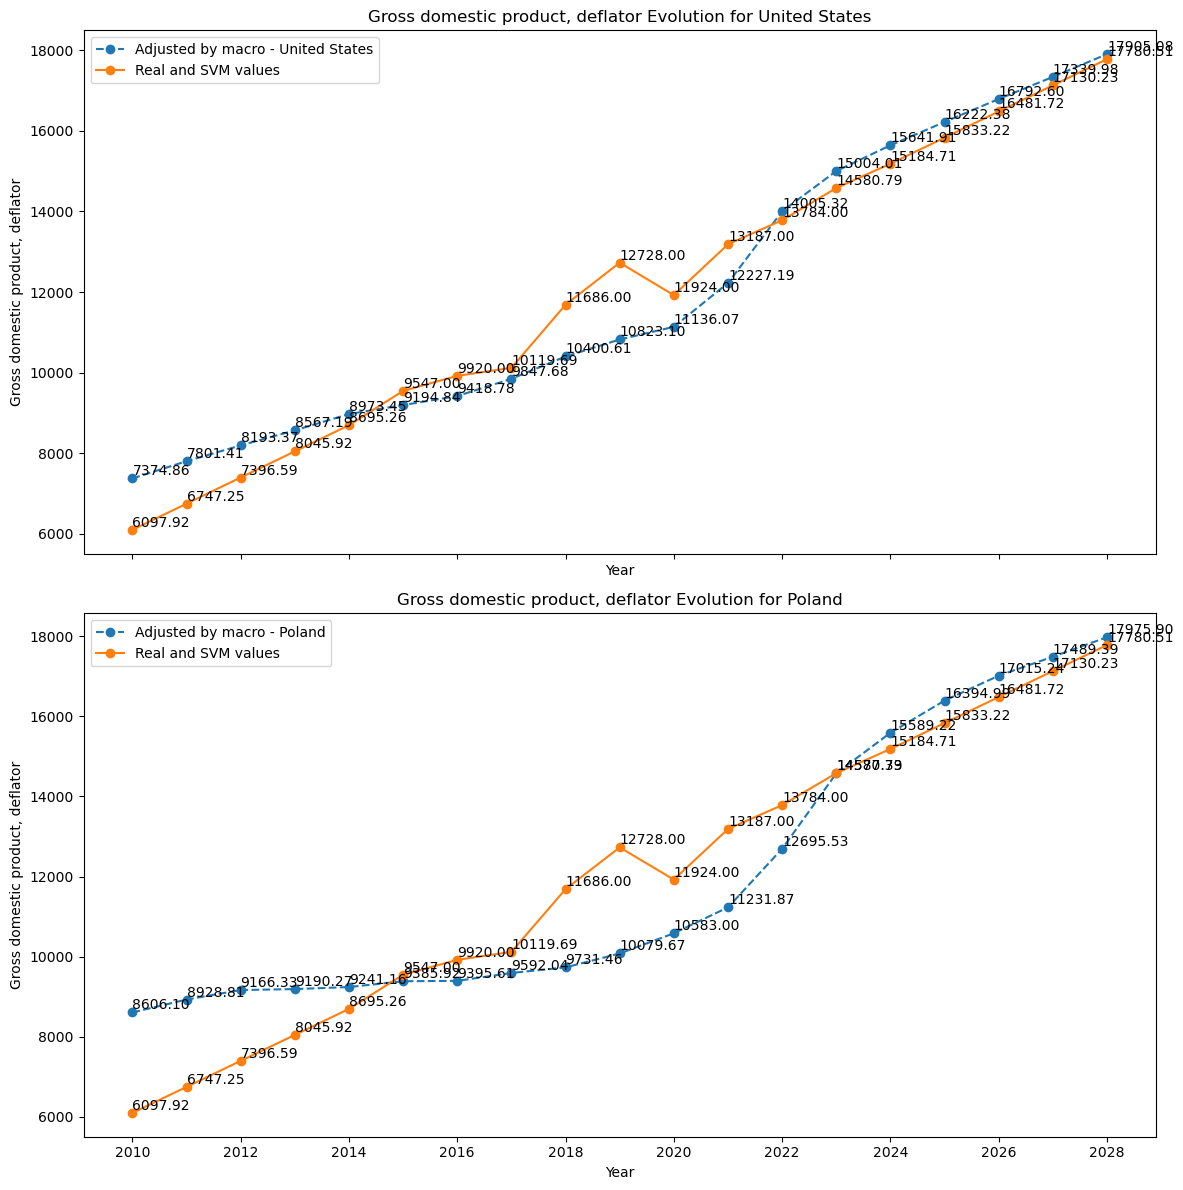

In [38]:
# Formula to create chart for selected Countires, Indicators and Model
def plot_country_evolution(evolution_df, annual_sum, countries, indicator):
    # ['Years'] and ['Date'] - convert each element to datetime
    evolution_df['Years'] = evolution_df['Years'].apply(lambda x: [pd.to_datetime(year, format='%Y') for year in x])
    annual_sum['Date'] = annual_sum['Date'].apply(lambda x: pd.to_datetime(x, format='%Y'))

    # Get unique countries
    unique_countries = evolution_df['Country'].unique()

    # Create subplots
    fig, axes = plt.subplots(nrows=len(countries), ncols=1, figsize=(12, 6 * len(countries)), sharex=True)

    for country, ax in zip(countries, axes):
        country_data = evolution_df[evolution_df['Country'] == country]

        # Plot
        ax.plot(country_data['Years'].values[0], country_data['Predicted_Values'].values[0],
                linestyle='dashed', marker='o', label=f'Adjusted by macro - {country}')

        for i, txt in enumerate(country_data['Predicted_Values'].values[0]):
            ax.text(country_data['Years'].values[0][i], txt, f'{txt:.2f}', ha='left', va='bottom')

        ax.plot(annual_sum['Date'], annual_sum['Value'], marker='o', label='Real and SVM values')

        for i, txt in enumerate(annual_sum['Value']):
            ax.text(annual_sum['Date'].values[i], txt, f'{txt:.2f}', ha='left', va='bottom')


        ax.set_title(f'{indicator} Evolution for {country}')
        ax.set_xlabel('Year')
        ax.set_ylabel(indicator)
        ax.legend()
        ax.grid(False)

    plt.tight_layout()
    plt.show()

plot_country_evolution(evolution_df, annual_sum, countries, indicator)

In [39]:
evolution_df

,Country,Indicator,Years,Predicted_Values,Coefficient,R-squared,Mean_Absolute_Error,Root_Mean_Squared_Error,Mean_Absolute_Percentage_Error
0,Poland,"Gross domestic product, deflator","[2010-01-01 00:00:00, 2011-01-01 00:00:00, 201...","[8606.09781307283, 8928.806744588972, 9166.328...",111.355739,0.854738,1074.112445,1356.069441,11.276268
1,United States,"Gross domestic product, deflator","[2010-01-01 00:00:00, 2011-01-01 00:00:00, 201...","[7374.864223946566, 7801.409901235493, 8193.37...",213.486325,0.951179,638.256246,786.154450,6.425479


# Merging real values (2016-2022) with imputed predictions (SVM) and those adjusted by macro indicator (OLS)

In [40]:
evolution_df['Date'] = evolution_df['Years'].apply(lambda x: x[0])
evolution_df['Country'] = evolution_df['Country']

# Explode the 'Years' and 'Predicted_Values' lists and create a new DataFrame
exploded_df = evolution_df.explode(['Years', 'Predicted_Values'])

# Extract individual values from the 'Years' column and change column names
exploded_df['Date'] = exploded_df['Years']
exploded_df['Date'] = pd.to_datetime(exploded_df['Date'])
exploded_df = exploded_df.drop('Years', axis=1)

result_df = exploded_df[['Country', 'Date', 'Predicted_Values']]
result_df

,Country,Date,Predicted_Values
0,Poland,2010-01-01,8606.097813
0,Poland,2011-01-01,8928.806745
0,Poland,2012-01-01,9166.328536
0,Poland,2013-01-01,9190.27002
0,Poland,2014-01-01,9241.159592
0,Poland,2015-01-01,9385.922053
0,Poland,2016-01-01,9395.610002
0,Poland,2017-01-01,9592.041526
0,Poland,2018-01-01,9731.458911
0,Poland,2019-01-01,10079.668307


In [41]:
# Make sure that Date columns are the same format... I know... I do that every time
result_df['Date'] = pd.to_datetime(result_df['Date'])
annual_sum['Date'] = pd.to_datetime(annual_sum['Date'])

# Again drop uncecessary columns
annual_sum = annual_sum.drop(['Company Name', 'Segment'], axis=1)

new_merged_df = pd.merge(annual_sum, result_df, on='Date', how='left')
new_merged_df

C:\Users\PLJAKRE\AppData\Local\Temp\ipykernel_1920\1333260350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['Date'] = pd.to_datetime(result_df['Date'])


,Date,Value,Country,Predicted_Values
0,2010-01-01,6097.917116,Poland,8606.097813
1,2010-01-01,6097.917116,United States,7374.864224
2,2011-01-01,6747.252048,Poland,8928.806745
3,2011-01-01,6747.252048,United States,7801.409901
4,2012-01-01,7396.586980,Poland,9166.328536
5,2012-01-01,7396.586980,United States,8193.370794
6,2013-01-01,8045.921911,Poland,9190.27002
7,2013-01-01,8045.921911,United States,8567.185349
8,2014-01-01,8695.256843,Poland,9241.159592
9,2014-01-01,8695.256843,United States,8973.449825


In [43]:
def assign_countries_to_none_rows(new_merged_df):
    new_df = new_merged_df.copy()

    # Filter rows where Country is None
    none_rows = new_df[new_df['Country'].isnull()]

    # Multiply the number of None rows by the number of unique countries (excluding None)
    num_unique_countries = len(new_merged_df['Country'].dropna().unique())
    total_rows_to_add = len(none_rows) * num_unique_countries

    # Assign unique countries to each date
    unique_dates = none_rows['Date'].unique()
    unique_countries = new_merged_df['Country'].dropna().unique()
    assigned_countries = np.tile(unique_countries, len(unique_dates))[:total_rows_to_add]

    # Concatenate the DataFrames
    df_duplicated = pd.concat([none_rows] * num_unique_countries, ignore_index=True)

    # Update the 'Country' column in df_duplicated
    if len(assigned_countries) > 0:
        df_duplicated['Country'] = np.tile(assigned_countries, len(df_duplicated) // len(assigned_countries) + 1)[:len(df_duplicated)]

    # Final merge
    result_df = pd.concat([df_duplicated, new_merged_df], ignore_index=True)

    # Final modelling
    result_df = result_df.dropna(subset=['Country'])
    result_df = result_df.sort_values(by=['Date', 'Country'])
    result_df = result_df[['Date', 'Country', 'Value', 'Predicted_Values']]
    final_result_df = result_df.reset_index(drop=True)

    return final_result_df

final_result_df = assign_countries_to_none_rows(new_merged_df)
final_result_df

,Date,Country,Value,Predicted_Values
0,2010-01-01,Poland,6097.917116,8606.097813
1,2010-01-01,United States,6097.917116,7374.864224
2,2011-01-01,Poland,6747.252048,8928.806745
3,2011-01-01,United States,6747.252048,7801.409901
4,2012-01-01,Poland,7396.586980,9166.328536
5,2012-01-01,United States,7396.586980,8193.370794
6,2013-01-01,Poland,8045.921911,9190.27002
7,2013-01-01,United States,8045.921911,8567.185349
8,2014-01-01,Poland,8695.256843,9241.159592
9,2014-01-01,United States,8695.256843,8973.449825


In [44]:
result_df.to_csv('final_result_df.csv', index=False)

# Final thoughts

Upon analyzing the parameters, it's apparent that the Ordinary Least Squares Regression (OLS) model proves to be quite effective. 

Additionally, our backup section contains a carefully compiled list of Macroeconomic indicators, offering the flexibility for the user to refine and tailor the forecast. Results vary across different countries and Macroeconomic indicators. 

The included code snippets in the backup provide the user with a practical guide to assess the model's suitability for specific countries and indicators.


# Backup section

In [48]:
def calculate_impact_statsmodels(df, target_col):
    impacts = []

    # Iterate over all columns except identification columns
    for feature_col in df.columns.difference(['Country', 'Date', 'Company Name', 'Segment', target_col]):
        for country in df['Country'].unique():
            country_df = df[df['Country'] == country]

            # Check for missing or infinite values in the input data
            if country_df[feature_col].isnull().values.any() or np.issubdtype(country_df[feature_col].dtype, np.number) and np.isinf(country_df[feature_col].values).any():
                print(f"Skipping {country} for {feature_col} due to missing or infinite values.")
                continue

            X = sm.add_constant(country_df[feature_col])
            y = country_df[target_col]

            model = sm.OLS(y, X).fit()

            # Check if the model has enough parameters
            if len(model.params) > 1:
                predictions = model.predict(X)
                
                mse = mean_squared_error(y, predictions)
                rmse = np.sqrt(mse)

                impact = {
                    'Country': country,
                    'Feature': feature_col,
                    'Coefficient': model.params[1],
                    'R-squared': model.rsquared,
                    'MSE': mse,
                    'RMSE': rmse
                }
                impacts.append(impact)

    impact_df = pd.DataFrame(impacts)

    # Calculate the top 10 countries with the highest impact
    top_countries = impact_df.groupby(['Country', 'Feature']).agg({
        'Coefficient': 'mean',
        'R-squared': 'mean',
        'MSE': 'mean',
        'RMSE': 'mean'
    }).sort_values(by='R-squared', ascending=False).head(10)

    return impact_df, top_countries

target_column = 'Value'

impact_df, top_countries = calculate_impact_statsmodels(merged_df, target_column)

top_countries

Skipping Poland for Gross domestic product per capita, constant prices due to missing or infinite values.
Skipping United States for Gross domestic product per capita, constant prices due to missing or infinite values.
Skipping Poland for Gross domestic product per capita, current prices due to missing or infinite values.
Skipping United States for Gross domestic product per capita, current prices due to missing or infinite values.
Skipping Poland for Gross domestic product, current prices due to missing or infinite values.
Skipping United States for Gross domestic product, current prices due to missing or infinite values.


Coefficient  R-squared  \
Country       Feature                                                           
United States Gross domestic product, deflator          213.486325   0.951179   
              Inflation, average consumer prices        168.888454   0.935266   
Poland        Gross domestic product, deflator          111.355739   0.854738   
United States General government gross debt             241.176249   0.842460   
Poland        Inflation, average consumer prices        125.968777   0.840476   
United States Current account balance                   -28.592715   0.654122   
Poland        General government gross debt             -14.517718   0.611383   
              Current account balance                   313.821807   0.298455   
United States Total investment                         2549.599020   0.257201   
Poland        Volume of exports of goods and services  -427.571848   0.199729   

                                                                MSE  \
Country       Feature                                                 
United States Gross domestic product, deflator         6.180388e+05   
              Inflation, average consumer prices       8.194906e+05   
Poland        Gross domestic product, deflator         1.838924e+06   
United States General government gross debt            1.994345e+06   
Poland        Inflation, average consumer prices       2.019468e+06   
United States Current account balance                  4.378576e+06   
Poland        General government gross debt            4.919624e+06   
              Current account balance                  8.881088e+06   
United States Total investment                         9.403334e+06   
Poland        Volume of exports of goods and services  1.013089e+07   

                                                              RMSE  
Country       Feature                                               
United States Gross domestic product, deflator          786.154450  
              Inflation, average consumer prices        905.257190  
Poland        Gross domestic product, deflator         1356.069441  
United States General government gross debt            1412.212789  
Poland        Inflation, average consumer prices       1421.079887  
United States Current account balance                  2092.504806  
Poland        General government gross debt            2218.022646  
              Current account balance                  2980.115464  
United States Total investment                         3066.485557  
Poland        Volume of exports of goods and services  3182.905874

Skipping Poland for Gross domestic product per capita, constant prices due to missing or infinite values.
Skipping United States for Gross domestic product per capita, constant prices due to missing or infinite values.
Skipping Poland for Gross domestic product per capita, current prices due to missing or infinite values.
Skipping United States for Gross domestic product per capita, current prices due to missing or infinite values.
Skipping Poland for Gross domestic product, current prices due to missing or infinite values.
Skipping United States for Gross domestic product, current prices due to missing or infinite values.


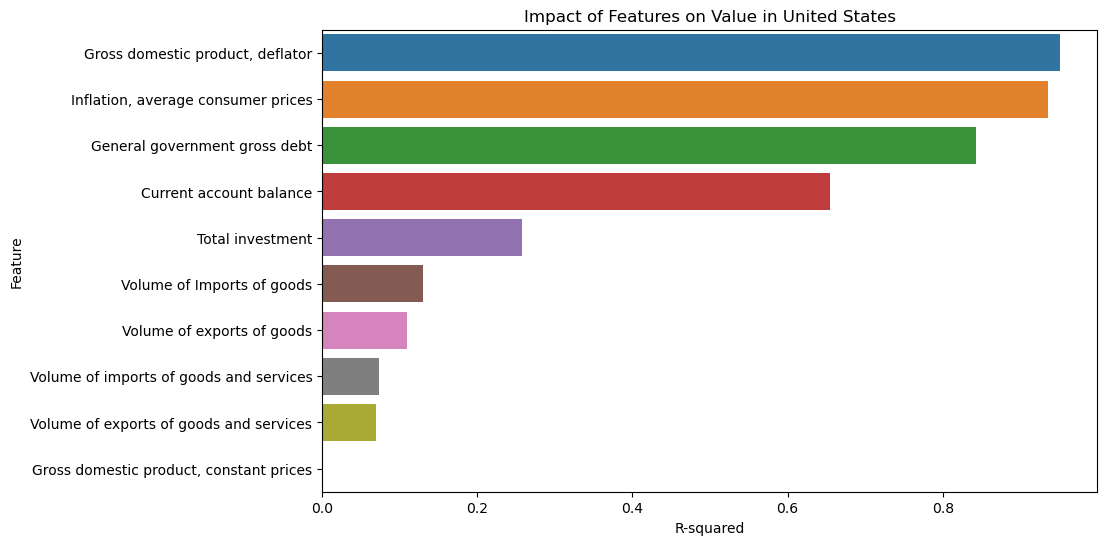

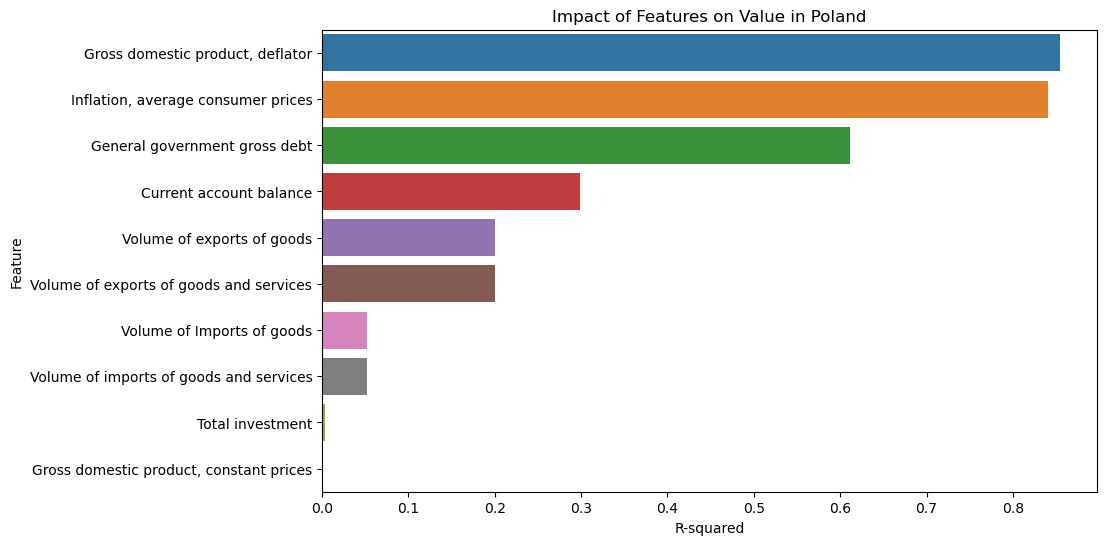

In [49]:
# Define a formula to see graphs presenting Indicator impact for each selected country
def plot_impact(impact_df, top_countries, target_col):
    for country in top_countries.index.get_level_values('Country').unique():
        country_impact = impact_df[impact_df['Country'] == country]
        country_impact = country_impact.sort_values(by='R-squared', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='R-squared', y='Feature', data=country_impact, ci=None)
        plt.title(f'Impact of Features on {target_col} in {country}')
        plt.xlabel('R-squared')
        plt.ylabel('Feature')
        plt.show()

impact_df, top_countries = calculate_impact_statsmodels(merged_df, target_column)

plot_impact(impact_df, top_countries, target_column)

In [ ]:
# Defining formula for Ordinary Leas Squares prediction model - all features
def calculate_impact_statsmodels(df, target_col):
    impacts = []

    # Iterate over all columns except identification columns
    for feature_col in df.columns.difference(['Country', 'Date', 'Company Name', 'Segment', target_col]):
        for country in df['Country'].unique():
            country_df = df[df['Country'] == country]

            # Convert to numeric type if 'object'
            if country_df[feature_col].dtype == 'object':
                country_df[feature_col] = pd.to_numeric(country_df[feature_col], errors='coerce')

            # Check for missing or infinite values in the input data
            if country_df[feature_col].isnull().values.any() or np.isinf(country_df[feature_col].values).any():
                print(f"Skipping {country} for {feature_col} due to missing or infinite values.")
                continue

            X = sm.add_constant(country_df[feature_col])
            y = country_df[target_col]

            model = sm.OLS(y, X).fit()

            # Check if the model has enough parameters
            if len(model.params) > 1:
                impact = {
                    'Country': country,
                    'Feature': feature_col,
                    'Value': y.values,
                    'Coefficient': model.params[1],
                    'R-squared': model.rsquared,
                    'Date': country_df['Date'].values
                }
                impacts.append(impact)

    return impact_df

impact_df